In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import binom

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Matplotlib 3.2.1



### 1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

In [4]:
# define gird size
N = 1000
# define grid
p_grid = np.arange(0, 1, 1/N)
# define prior
prior = np.ones(N)
# compute likelihood at each value in grid
likelihood = binom.pmf(8, 15, p_grid)
# compute product of likelihood and prior
posterior = likelihood*prior
# standardize the posterior, so it sums to 1
posterior = posterior/sum(posterior)

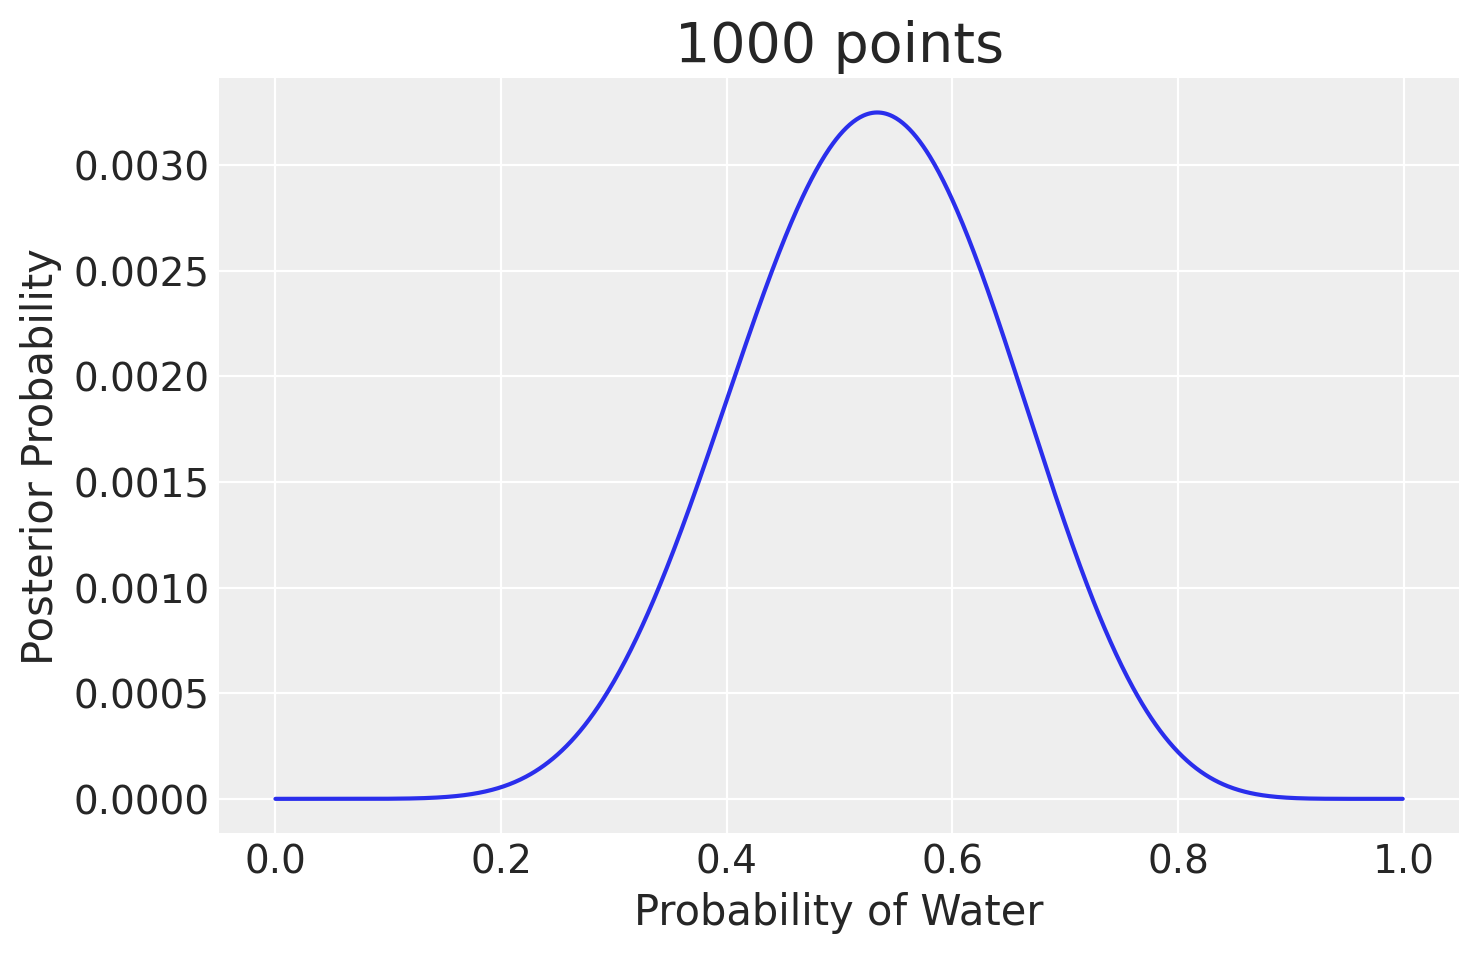

In [5]:
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(p_grid, posterior, '-')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Posterior Probability', fontsize=15)
plt.title('{} points'.format(N), fontsize=20)
plt.show()

In [6]:
samples1 = np.random.choice(p_grid, size=10000, replace=True, p=posterior)
np.mean(samples1)

0.5297259

In [7]:
perc_range1 = np.percentile(samples1, [0.5, 99.5])
print(perc_range1)

[0.241    0.805005]


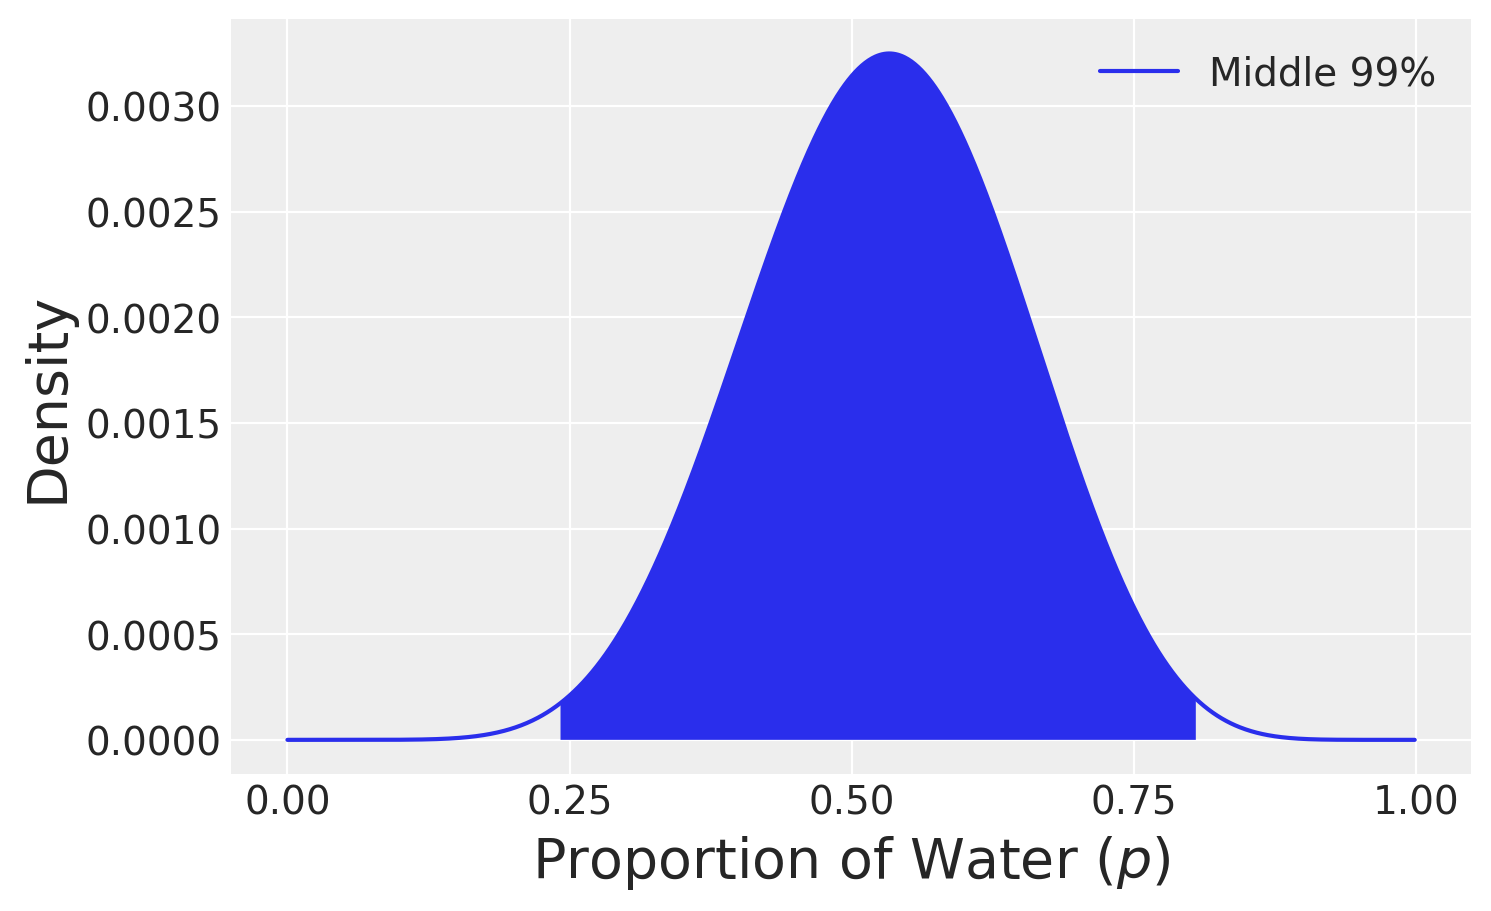

In [8]:
# plot p > 0.05 & p < 0.995
fig = plt.figure(figsize=(8, 5))
plt.plot(p_grid, posterior, label = "Middle 99%")
plt.xlabel('Proportion of Water ($p$)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks([0, 0.25, 0.50, 0.75, 1.00])
plt.fill_between(p_grid, posterior, where = (p_grid > perc_range1[0])&(p_grid < perc_range1[1]))
plt.legend(loc=0)
plt.show()

### 2. Start over in 1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water. What difference does the better prior make? If it helps, compare posterior distributions (using both priors) to the true value p = 0.7.

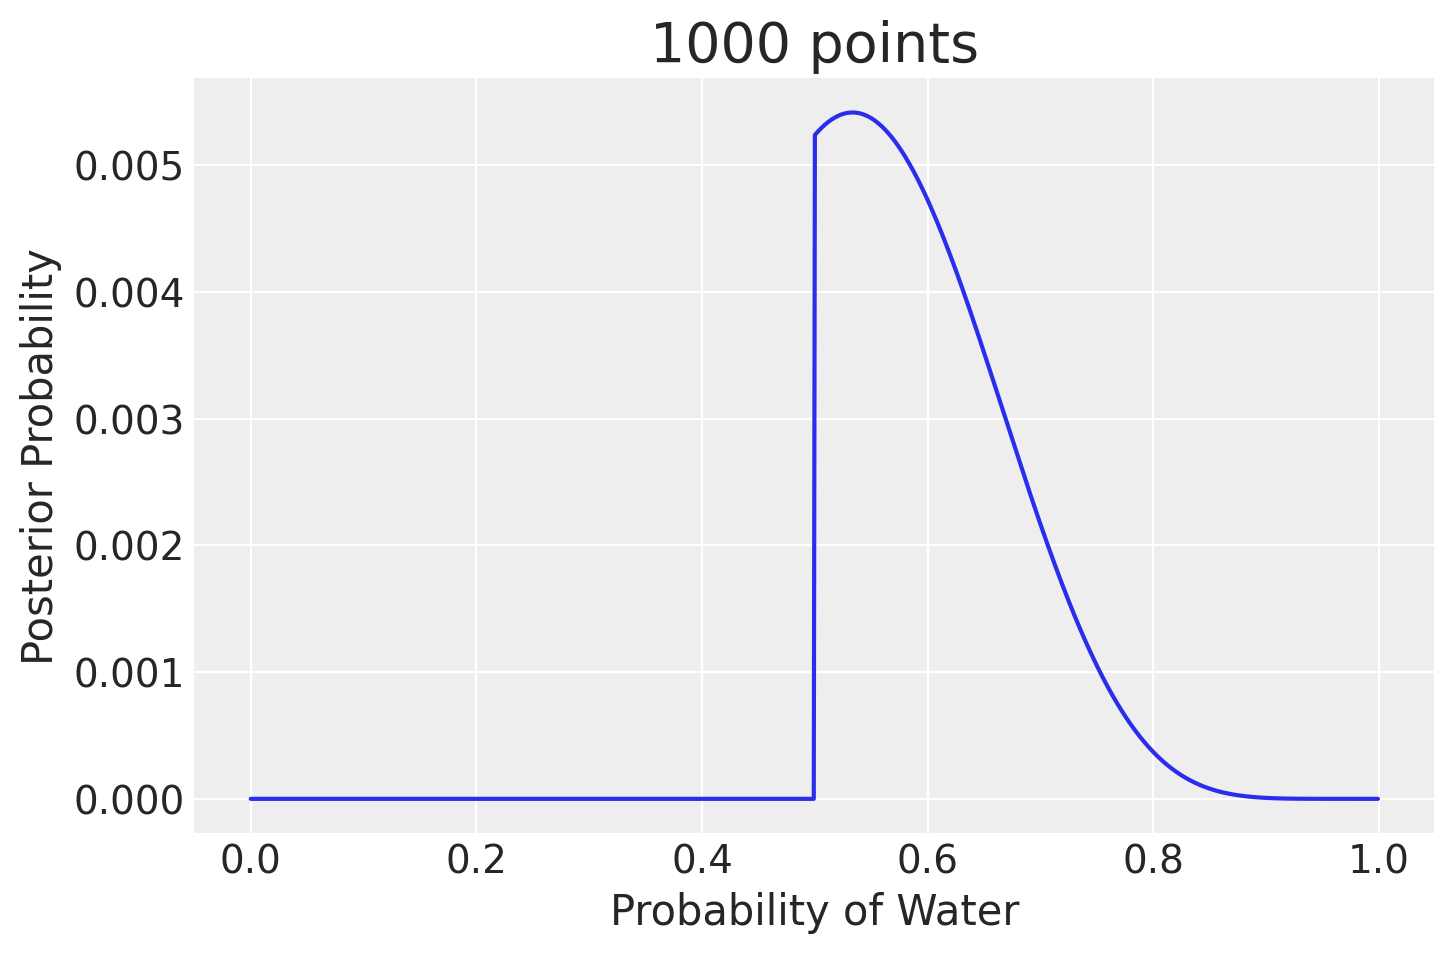

In [9]:
# define gird size
N = 1000
# define grid
p_grid = np.arange(0, 1, 1/N)
# define prior
prior = np.ones(N)
prior[p_grid<0.5] = 0.
# compute likelihood at each value in grid
likelihood = binom.pmf(8, 15, p_grid)
# compute product of likelihood and prior
posterior = likelihood*prior
# standardize the posterior, so it sums to 1
posterior = posterior/sum(posterior)
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(p_grid, posterior, '-')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Posterior Probability', fontsize=15)
plt.title('{} points'.format(N), fontsize=20)
plt.show()

In [10]:
samples2 = np.random.choice(p_grid, size=10000, replace=True, p=posterior)
np.mean(samples2)

0.6065645000000001

In [11]:
perc_range2 = np.percentile(samples2, [0.5, 99.5])
print(perc_range2)

[0.501 0.822]


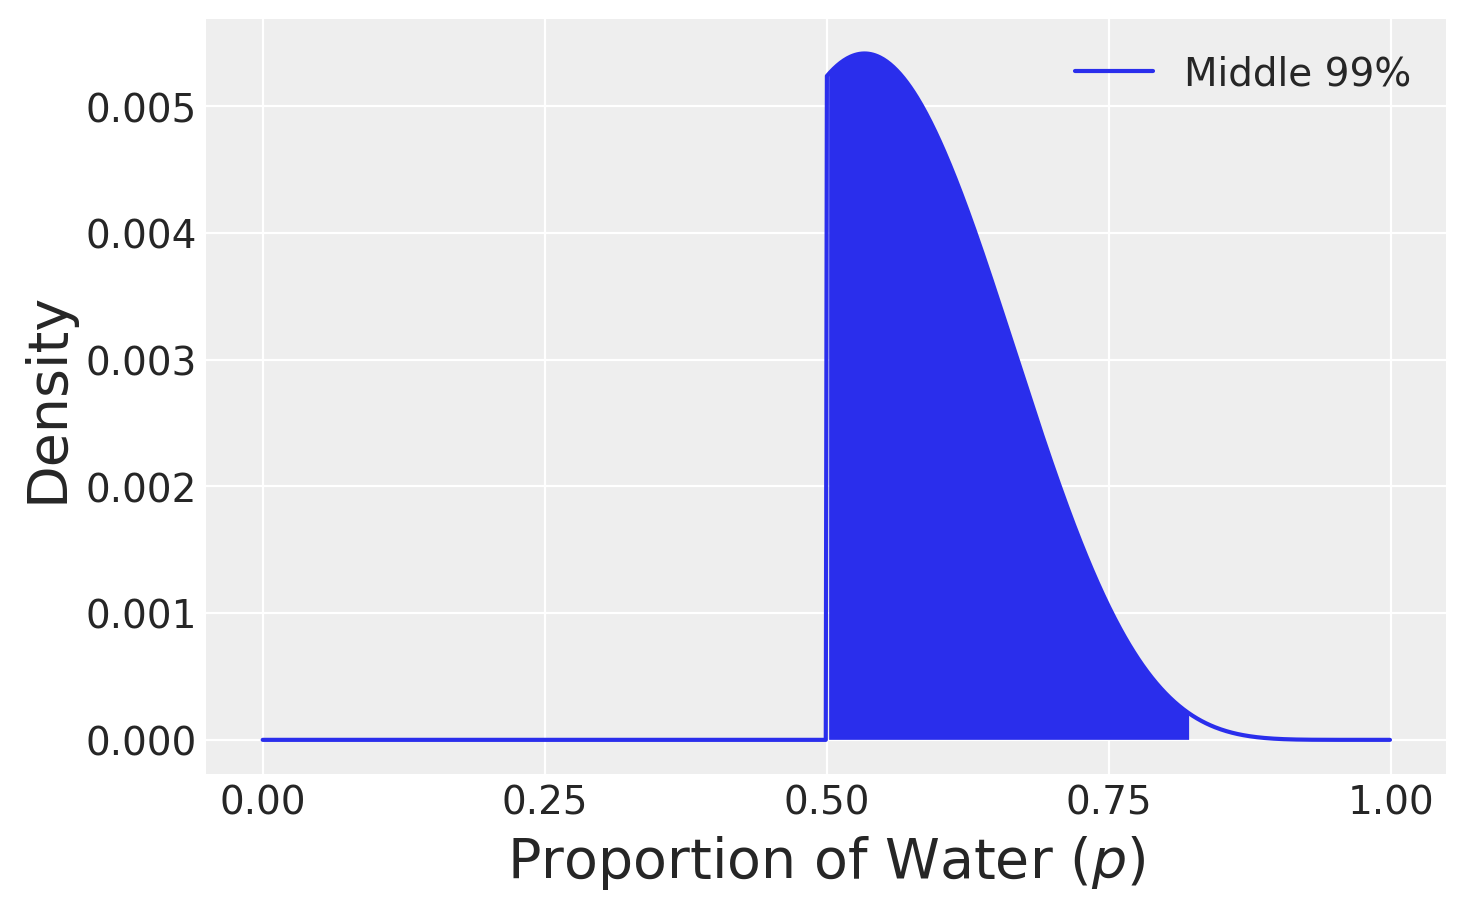

In [12]:
# plot p > 0.05 & p < 0.995
fig = plt.figure(figsize=(8, 5))
plt.plot(p_grid, posterior, label = "Middle 99%")
plt.xlabel('Proportion of Water ($p$)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks([0, 0.25, 0.50, 0.75, 1.00])
plt.fill_between(p_grid, posterior, where = (p_grid > perc_range2[0])&(p_grid < perc_range2[1]))
plt.legend(loc=0)
plt.show()

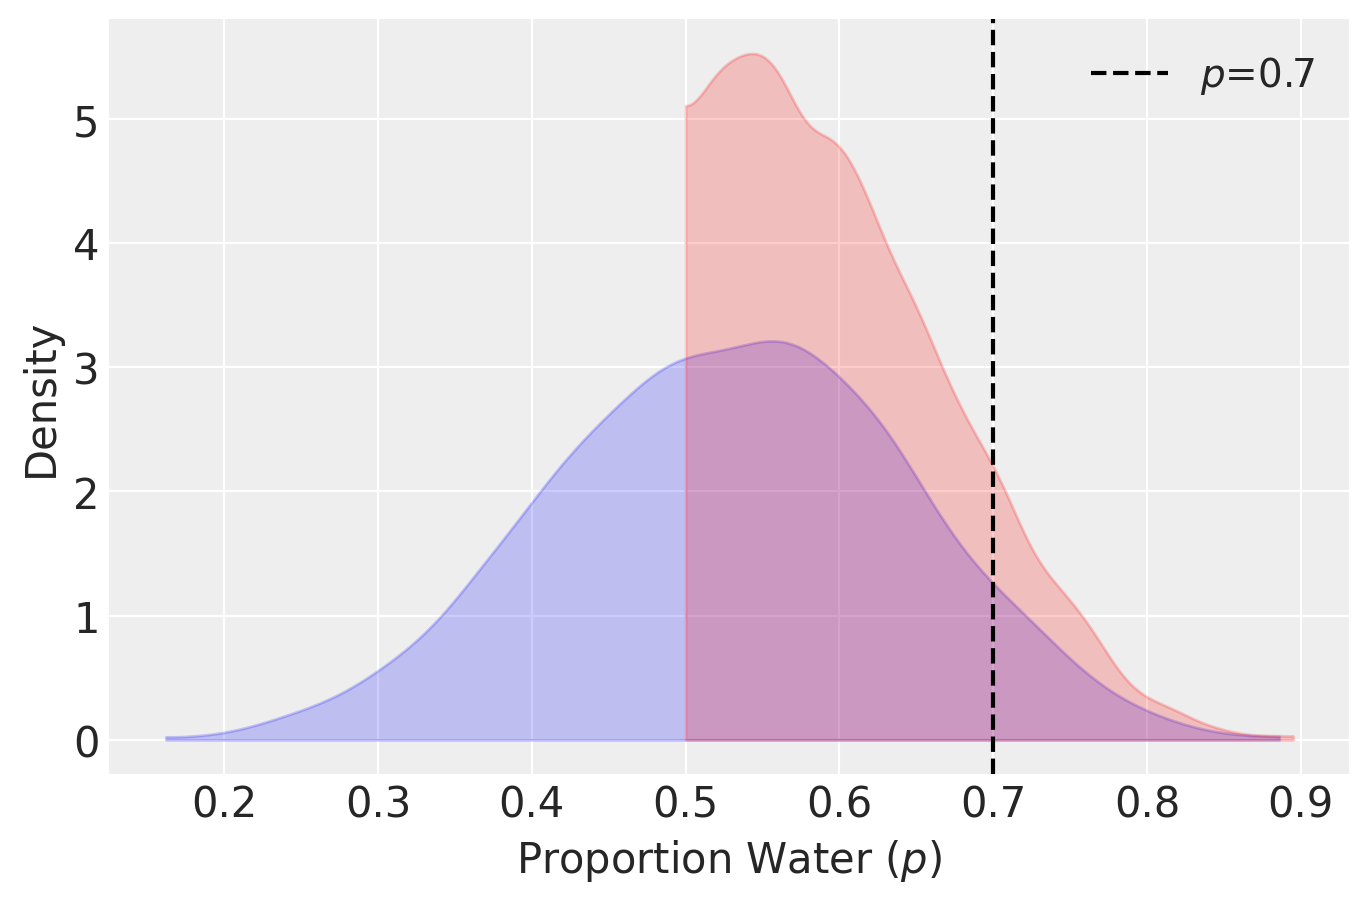

In [13]:
# plot figure
fig = plt.figure(figsize=(8, 5))
az.plot_kde(samples1, plot_kwargs={"linewidth":0, "color":"blue"}, fill_kwargs={"alpha":.2})
az.plot_kde(samples2, plot_kwargs={"linewidth":0, "color":"red"}, fill_kwargs={"alpha":.2})
plt.axvline(x=0.7, c='k', linestyle='--',label='$p$=0.7')
plt.legend()
plt.xlabel('Proportion Water ($p$)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

### 3. This problem is more open-ended than the others. Feel free to collaborate on the solution. Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this? I won’t require a precise answer. I’m honestly more interested in your approach.

In [14]:
def globe_tosses(p_true, NTimes, p_grid, prior):
    # generate number of water counts
    W = sum(binom.rvs(1, p_true, size=NTimes))
    # compute likelihood at each value in grid
    likelihood = binom.pmf(W, NTimes, p_grid)
    # compute product of likelihood and prior
    posterior = likelihood*prior
    # standardize the posterior, so it sums to 1
    posterior = posterior/sum(posterior)
    # draw samples from posterior 
    samples = np.random.choice(p_grid, size=10000, replace=True, p=posterior)
    # calculate 99% percentile interval
    perc_range = np.percentile(samples, [0.5, 99.5])
    # return results
    return posterior, perc_range

In [15]:
# define ture p
p_true = 0.7
# define gird size
N = 1000
# define grid
p_grid = np.arange(0, 1, 1/N)
# define prior
prior = np.ones(N)
# find minmum tosses
for NTimes in range(5000):
    posterior, perc_range = globe_tosses(p_true, NTimes, p_grid, prior)
    print('Tosse #', NTimes, 'Width:', perc_range[1]-perc_range[0])
    if perc_range[1]-perc_range[0]<0.05:
        print('Minmum tosses:', NTimes)
        break

Tosse # 0 Width: 0.99
Tosse # 1 Width: 0.927
Tosse # 2 Width: 0.923
Tosse # 3 Width: 0.737015
Tosse # 4 Width: 0.8300000000000001
Tosse # 5 Width: 0.723
Tosse # 6 Width: 0.6660149999999991
Tosse # 7 Width: 0.7190000000000001
Tosse # 8 Width: 0.6380000000000001
Tosse # 9 Width: 0.6210049999999999
Tosse # 10 Width: 0.5760049999999991
Tosse # 11 Width: 0.617005
Tosse # 12 Width: 0.5840099999999993
Tosse # 13 Width: 0.594
Tosse # 14 Width: 0.597
Tosse # 15 Width: 0.5230099999999993
Tosse # 16 Width: 0.4630149999999985
Tosse # 17 Width: 0.44799999999999995
Tosse # 18 Width: 0.508005
Tosse # 19 Width: 0.49700999999999923
Tosse # 20 Width: 0.512
Tosse # 21 Width: 0.49201499999999926
Tosse # 22 Width: 0.48
Tosse # 23 Width: 0.387
Tosse # 24 Width: 0.42500000000000004
Tosse # 25 Width: 0.424005
Tosse # 26 Width: 0.43300499999999925
Tosse # 27 Width: 0.37100499999999925
Tosse # 28 Width: 0.445
Tosse # 29 Width: 0.41601499999999836
Tosse # 30 Width: 0.373
Tosse # 31 Width: 0.4180099999999992
Toss

Tosse # 235 Width: 0.14800500000000005
Tosse # 236 Width: 0.16199999999999992
Tosse # 237 Width: 0.14400000000000002
Tosse # 238 Width: 0.14600500000000005
Tosse # 239 Width: 0.15400499999999928
Tosse # 240 Width: 0.15000500000000005
Tosse # 241 Width: 0.14800000000000002
Tosse # 242 Width: 0.15000000000000002
Tosse # 243 Width: 0.15300000000000002
Tosse # 244 Width: 0.14800000000000002
Tosse # 245 Width: 0.14
Tosse # 246 Width: 0.15100499999999994
Tosse # 247 Width: 0.15300000000000002
Tosse # 248 Width: 0.15100500000000006
Tosse # 249 Width: 0.14800000000000002
Tosse # 250 Width: 0.14900000000000002
Tosse # 251 Width: 0.14800000000000002
Tosse # 252 Width: 0.15499999999999992
Tosse # 253 Width: 0.14400500000000005
Tosse # 254 Width: 0.14600500000000005
Tosse # 255 Width: 0.14
Tosse # 256 Width: 0.14400000000000002
Tosse # 257 Width: 0.1510099999999992
Tosse # 258 Width: 0.14400500000000005
Tosse # 259 Width: 0.14
Tosse # 260 Width: 0.15800000000000003
Tosse # 261 Width: 0.14100000000

Tosse # 488 Width: 0.1050049999999999
Tosse # 489 Width: 0.10599999999999998
Tosse # 490 Width: 0.10799999999999998
Tosse # 491 Width: 0.10600500000000002
Tosse # 492 Width: 0.10799999999999998
Tosse # 493 Width: 0.10499999999999998
Tosse # 494 Width: 0.1060049999999999
Tosse # 495 Width: 0.10500500000000001
Tosse # 496 Width: 0.10399999999999998
Tosse # 497 Width: 0.10900499999999913
Tosse # 498 Width: 0.10599999999999998
Tosse # 499 Width: 0.1040049999999999
Tosse # 500 Width: 0.10300499999999913
Tosse # 501 Width: 0.10399999999999998
Tosse # 502 Width: 0.1070049999999999
Tosse # 503 Width: 0.1060049999999999
Tosse # 504 Width: 0.10599999999999998
Tosse # 505 Width: 0.10099999999999998
Tosse # 506 Width: 0.10800500000000002
Tosse # 507 Width: 0.10499999999999998
Tosse # 508 Width: 0.10799999999999998
Tosse # 509 Width: 0.10599999999999998
Tosse # 510 Width: 0.10299999999999998
Tosse # 511 Width: 0.10499999999999998
Tosse # 512 Width: 0.10399999999999998
Tosse # 513 Width: 0.103005000

Tosse # 721 Width: 0.08299999999999996
Tosse # 722 Width: 0.08799999999999997
Tosse # 723 Width: 0.08699999999999997
Tosse # 724 Width: 0.08899999999999997
Tosse # 725 Width: 0.08899999999999997
Tosse # 726 Width: 0.08999999999999997
Tosse # 727 Width: 0.08699999999999997
Tosse # 728 Width: 0.08599999999999997
Tosse # 729 Width: 0.08799999999999997
Tosse # 730 Width: 0.08799999999999997
Tosse # 731 Width: 0.08700499999999989
Tosse # 732 Width: 0.08700499999999911
Tosse # 733 Width: 0.08399999999999996
Tosse # 734 Width: 0.08699999999999997
Tosse # 735 Width: 0.08799999999999997
Tosse # 736 Width: 0.08499999999999996
Tosse # 737 Width: 0.08599999999999997
Tosse # 738 Width: 0.086005
Tosse # 739 Width: 0.08699999999999997
Tosse # 740 Width: 0.08499999999999996
Tosse # 741 Width: 0.08699999999999997
Tosse # 742 Width: 0.08499999999999996
Tosse # 743 Width: 0.08799999999999997
Tosse # 744 Width: 0.088005
Tosse # 745 Width: 0.08700499999999922
Tosse # 746 Width: 0.08699999999999997
Tosse # 

Tosse # 1022 Width: 0.07499999999999996
Tosse # 1023 Width: 0.07199999999999995
Tosse # 1024 Width: 0.07299999999999995
Tosse # 1025 Width: 0.07199999999999995
Tosse # 1026 Width: 0.07399999999999995
Tosse # 1027 Width: 0.07399999999999995
Tosse # 1028 Width: 0.07399999999999995
Tosse # 1029 Width: 0.07299999999999995
Tosse # 1030 Width: 0.07200499999999921
Tosse # 1031 Width: 0.07399999999999995
Tosse # 1032 Width: 0.07099999999999995
Tosse # 1033 Width: 0.07199999999999995
Tosse # 1034 Width: 0.07099999999999995
Tosse # 1035 Width: 0.07299999999999995
Tosse # 1036 Width: 0.07299999999999995
Tosse # 1037 Width: 0.07199999999999995
Tosse # 1038 Width: 0.07299999999999995
Tosse # 1039 Width: 0.07099999999999995
Tosse # 1040 Width: 0.06999999999999995
Tosse # 1041 Width: 0.07399999999999995
Tosse # 1042 Width: 0.07299999999999995
Tosse # 1043 Width: 0.07399999999999995
Tosse # 1044 Width: 0.07599999999999996
Tosse # 1045 Width: 0.07200499999999999
Tosse # 1046 Width: 0.07199999999999995


Tosse # 1326 Width: 0.06599999999999995
Tosse # 1327 Width: 0.06299999999999994
Tosse # 1328 Width: 0.06399999999999995
Tosse # 1329 Width: 0.06599999999999995
Tosse # 1330 Width: 0.06400499999999909
Tosse # 1331 Width: 0.06399999999999995
Tosse # 1332 Width: 0.0670049999999991
Tosse # 1333 Width: 0.06699999999999995
Tosse # 1334 Width: 0.06499999999999995
Tosse # 1335 Width: 0.0630049999999992
Tosse # 1336 Width: 0.06700000000000006
Tosse # 1337 Width: 0.06499999999999995
Tosse # 1338 Width: 0.06600499999999998
Tosse # 1339 Width: 0.06599999999999995
Tosse # 1340 Width: 0.06499999999999995
Tosse # 1341 Width: 0.06299999999999994
Tosse # 1342 Width: 0.06499999999999995
Tosse # 1343 Width: 0.06399999999999995
Tosse # 1344 Width: 0.06599999999999995
Tosse # 1345 Width: 0.06300499999999998
Tosse # 1346 Width: 0.06499999999999995
Tosse # 1347 Width: 0.06299999999999994
Tosse # 1348 Width: 0.061999999999999944
Tosse # 1349 Width: 0.06399999999999995
Tosse # 1350 Width: 0.06200499999999998
T

Tosse # 1629 Width: 0.05800499999999986
Tosse # 1630 Width: 0.05899999999999994
Tosse # 1631 Width: 0.05699999999999994
Tosse # 1632 Width: 0.05999999999999994
Tosse # 1633 Width: 0.05799999999999994
Tosse # 1634 Width: 0.05699999999999994
Tosse # 1635 Width: 0.05799999999999994
Tosse # 1636 Width: 0.05699999999999994
Tosse # 1637 Width: 0.05599999999999994
Tosse # 1638 Width: 0.05699999999999994
Tosse # 1639 Width: 0.05799999999999994
Tosse # 1640 Width: 0.05799999999999994
Tosse # 1641 Width: 0.05899999999999994
Tosse # 1642 Width: 0.05799999999999994
Tosse # 1643 Width: 0.05699999999999994
Tosse # 1644 Width: 0.05899999999999994
Tosse # 1645 Width: 0.05699999999999994
Tosse # 1646 Width: 0.05899999999999994
Tosse # 1647 Width: 0.05799999999999994
Tosse # 1648 Width: 0.05799999999999994
Tosse # 1649 Width: 0.05699999999999994
Tosse # 1650 Width: 0.05799999999999994
Tosse # 1651 Width: 0.05799999999999994
Tosse # 1652 Width: 0.05799999999999994
Tosse # 1653 Width: 0.05799999999999994


Tosse # 1921 Width: 0.05200499999999908
Tosse # 1922 Width: 0.05499999999999994
Tosse # 1923 Width: 0.052999999999999936
Tosse # 1924 Width: 0.05399999999999994
Tosse # 1925 Width: 0.05499999999999994
Tosse # 1926 Width: 0.05100499999999997
Tosse # 1927 Width: 0.05399999999999994
Tosse # 1928 Width: 0.05399999999999994
Tosse # 1929 Width: 0.053009999999999224
Tosse # 1930 Width: 0.05399999999999994
Tosse # 1931 Width: 0.052999999999999936
Tosse # 1932 Width: 0.05300499999999986
Tosse # 1933 Width: 0.052999999999999936
Tosse # 1934 Width: 0.05399999999999994
Tosse # 1935 Width: 0.05399999999999994
Tosse # 1936 Width: 0.051999999999999935
Tosse # 1937 Width: 0.05399999999999994
Tosse # 1938 Width: 0.051999999999999935
Tosse # 1939 Width: 0.052999999999999936
Tosse # 1940 Width: 0.052999999999999936
Tosse # 1941 Width: 0.052999999999999936
Tosse # 1942 Width: 0.05399999999999994
Tosse # 1943 Width: 0.052999999999999936
Tosse # 1944 Width: 0.05399999999999994
Tosse # 1945 Width: 0.05399999

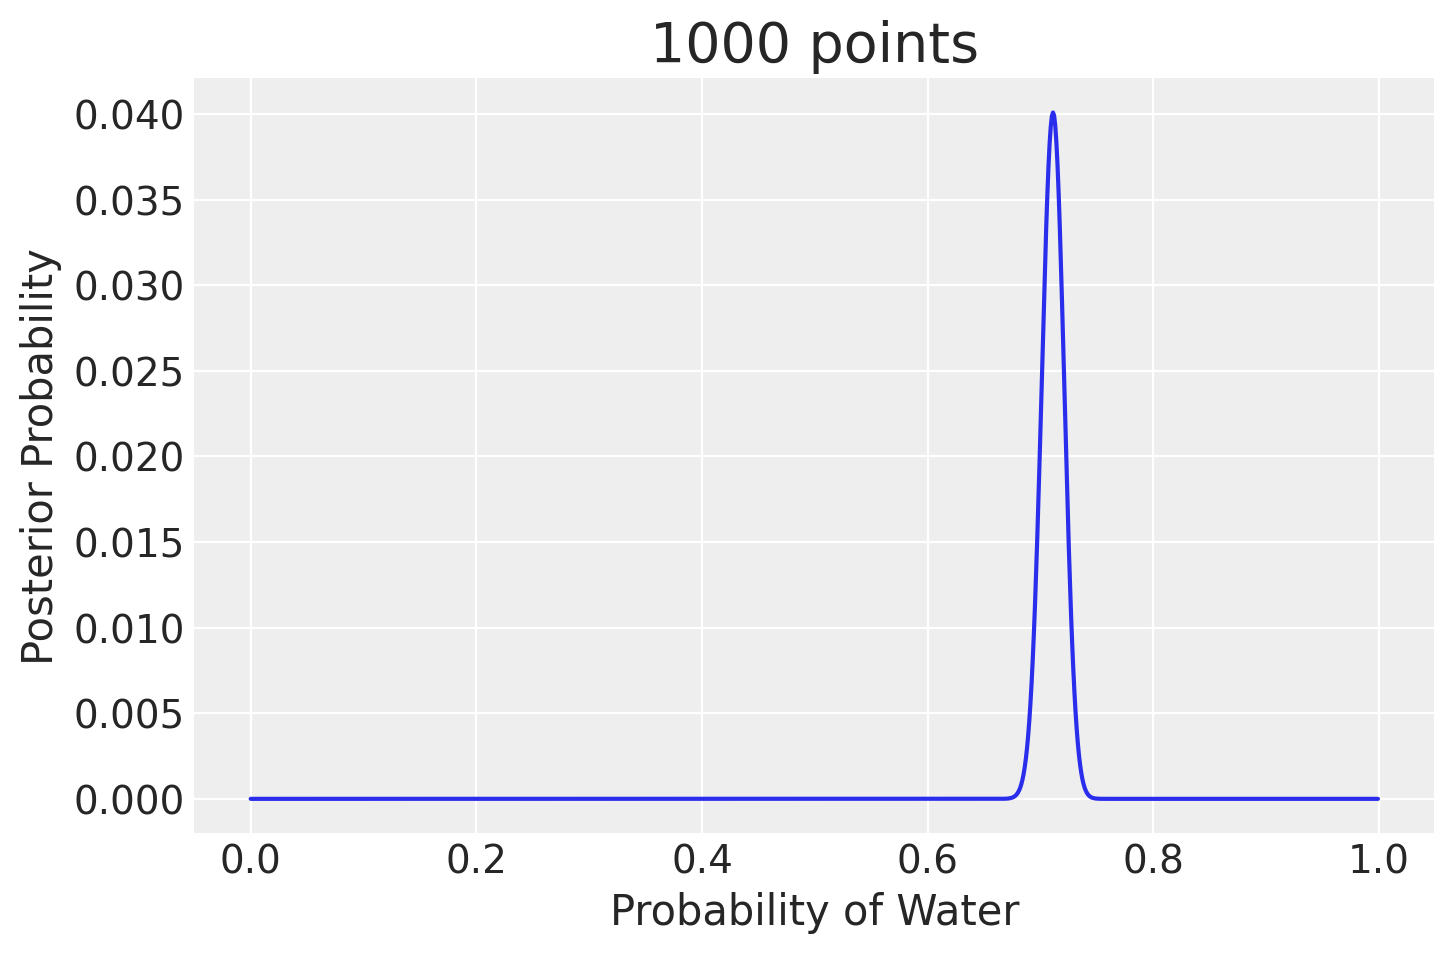

In [16]:
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(p_grid, posterior, '-')
plt.xlabel('Probability of Water', fontsize=15)
plt.ylabel('Posterior Probability', fontsize=15)
plt.title('{} points'.format(N), fontsize=20)
plt.show()